In [0]:
#!pip3 -qq install torch
#!pip3 -qq install bokeh==0.13.0
#!pip3 -qq install gensim==3.6.0
#!pip3 -qq install nltk
#!pip3 -qq install scikit-learn==0.20.2

In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

In [0]:
print(torch.cuda.is_available())

True


In [0]:
import nltk
from sklearn.model_selection import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [0]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

The            	DET
Fulton         	NOUN
County         	NOUN
Grand          	ADJ
Jury           	NOUN
said           	VERB
Friday         	NOUN
an             	DET
investigation  	NOUN
of             	ADP
Atlanta's      	NOUN
recent         	ADJ
primary        	NOUN
election       	NOUN
produced       	VERB
``             	.
no             	DET
evidence       	NOUN
''             	.
that           	ADP
any            	DET
irregularities 	NOUN
took           	VERB
place          	NOUN
.              	.


In [0]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


In [0]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'PRON', 'VERB', '.', 'ADP', 'ADV', 'DET', 'NUM', 'CONJ', 'X', 'PRT', 'NOUN', 'ADJ'}


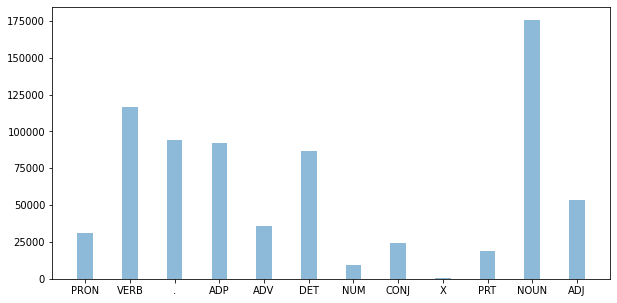

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

In [0]:
import nltk

default_tagger = nltk.DefaultTagger('NN')

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))

Accuracy of unigram tagger = 92.62%


In [0]:
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

Accuracy of bigram tagger = 93.42%


In [0]:
trigram_tagger = nltk.TrigramTagger(train_data)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

Accuracy of trigram tagger = 23.33%


In [0]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [0]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start:end]
        
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [0]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch.shape, y_batch.shape

((32, 4), (32, 4))

In [0]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super(LSTMTagger, self).__init__()

        self.lstm_hidden_dim = lstm_hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, word_emb_dim)

        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, num_layers=lstm_layers_count)
        self.hidden2tag = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        embeds = self.word_embeddings(inputs)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out)
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [0]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)

def calc_accuracy(logits, y_batch):
    outs = torch.argmax(logits, dim=-1)
    reals = ((outs == y_batch).float() * (y_batch != 0).float()).sum().item()
    totals = (y_batch != 0).float().sum().item()
    return reals, totals

In [0]:
criterion = nn.CrossEntropyLoss()
criterion(logits.view(-1, logits.shape[-1]), y_batch.view(-1)).item()

2.5506138801574707

In [0]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                logits = model(X_batch)

                loss = criterion(logits.view(-1, logits.shape[-1]), y_batch.view(-1))
                
                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                cur_correct_count, cur_sum_count = calc_accuracy(logits, y_batch)

                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')

In [0]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[5 / 5]   Val: Loss = 0.14944, Accuracy = 90.45%: 100%|██████████| 13/13 [00:00<00:00, 67.16it/s]


In [0]:
correct = 0
total = 0

for X_batch, y_batch in iterate_batches((X_test, y_test), 64):
    X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
    logits = model(X_batch)
    mask = (y_batch != 0).float()
    preds = torch.argmax(logits, dim=-1)
    correct += ((preds == y_batch).float() * mask).sum()
    total += mask.sum()

print(correct/total)

tensor(0.8785, device='cuda:0')


In [0]:
class BidirectionalLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self.word_embeddings = nn.Embedding(vocab_size, word_emb_dim)
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, num_layers=lstm_layers_count, bidirectional=True)
        self.hidden_to_tag = nn.Linear(2 * lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        embeddings = self.word_embeddings(inputs)
        lstm_out, _ = self.lstm(embeddings)
        tag_space = self.hidden_to_tag(lstm_out)
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

model = BidirectionalLSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.59500, Accuracy = 81.68%: 100%|██████████| 572/572 [00:07<00:00, 78.13it/s]
[1 / 50]   Val: Loss = 0.29673, Accuracy = 90.31%: 100%|██████████| 13/13 [00:00<00:00, 48.14it/s]
[2 / 50] Train: Loss = 0.22864, Accuracy = 92.80%: 100%|██████████| 572/572 [00:07<00:00, 78.16it/s]
[2 / 50]   Val: Loss = 0.20340, Accuracy = 93.26%: 100%|██████████| 13/13 [00:00<00:00, 48.27it/s]
[3 / 50] Train: Loss = 0.15022, Accuracy = 95.39%: 100%|██████████| 572/572 [00:07<00:00, 78.88it/s]
[3 / 50]   Val: Loss = 0.15706, Accuracy = 94.88%: 100%|██████████| 13/13 [00:00<00:00, 49.32it/s]
[4 / 50] Train: Loss = 0.10881, Accuracy = 96.71%: 100%|██████████| 572/572 [00:07<00:00, 77.91it/s]
[4 / 50]   Val: Loss = 0.14094, Accuracy = 95.32%: 100%|██████████| 13/13 [00:00<00:00, 47.67it/s]
[5 / 50] Train: Loss = 0.07961, Accuracy = 97.59%: 100%|██████████| 572/572 [00:07<00:00, 78.64it/s]
[5 / 50]   Val: Loss = 0.13530, Accuracy = 95.49%: 100%|██████████| 13/13 [00:00<00:00, 50.13it/s]


In [0]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 38736 out of 45441 word embeddings


In [0]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super().__init__()
        self.word_embeddings = nn.Embedding.from_pretrained(embeddings)
        self.lstm = nn.LSTM(embeddings.shape[1], lstm_hidden_dim, num_layers=lstm_layers_count, bidirectional=True)
        self.hidden_to_tag = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        embeddings = self.word_embeddings(inputs)
        lstm_out, _ = self.lstm(embeddings)
        tag_space = self.hidden_to_tag(lstm_out)
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [0]:
correct = 0
total = 0

for X_batch, y_batch in iterate_batches((X_test, y_test), 64):
    X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
    logits = model(X_batch)
    mask = (y_batch != 0).float()
    preds = torch.argmax(logits, dim=-1)
    correct += ((preds == y_batch).float() * mask).sum()
    total += mask.sum()

print(correct/total)

tensor(0.9571, device='cuda:0')
